In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline


In [2]:
from cobra.io import read_sbml_model
model = read_sbml_model('iML1515.xml')

## Altering 3 genes involved in L-serine in- and export resulted in L-serine production

Results from the FVA and FSEOF analyses, along with the reactions the metabolite ser__L_p (L-serine in the periplasm) participates in, were investigated manually in the model. 


In [4]:
model.metabolites.ser__L_p.summary()

Below is reported first the interesting fluxes and yield from the wild type model. 
Hereafter, the model was altered by manually testing out some of the results from the FSEOF analysis (the ones that seemed to have been changed the most in the analysis). Also what seemed most effectful from the FVA analysis was included, and finally some of the reactions from the reaction summary of the metabolite ser__L_p was knocked out or the flux altered to investigate the effect on serine production and biomass. 

These gene alterations resulted in L-serine production when optimizing for biomass, meaning the cells would be able to grow while also producing and exporting our amino acid. Inactivating the gene alterations (by making them into a comment, #) revealed that only 3 gene alterations were necessary for serine production. 

In [22]:
# TESTING OUT A LOT

with model:
    print("WT")
    solution = model.optimize()
    print('Biomass flux: ', solution.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
    print('Glucose flux: ', solution.fluxes.EX_glc__D_e)
    print('Serine efflux: ',solution.fluxes.EX_ser__L_e)
    print("Yield on glucose: ", solution.fluxes.EX_ser__L_e / (-1*model.reactions.EX_glc__D_e.flux))


print('-------------------------------------------------')
print('')
print('-------------------------------------------------')
    
with model:
    print("ALTERED")
    
    # From FSEOF:
    #model.reactions.PFK_3.bounds = 9.5,1000
    #model.reactions.PGI.bounds = 10,1000
    #model.reactions.PGK.bounds = -19,-19
    #model.reactions.PGL.knock_out()
    #model.reactions.PYK.knock_out()
    #model.reactions.GND.knock_out()
    #model.reactions.G6PDH2r.knock_out()
    #model.reactions.PSERT.bounds = 18,1000
    #model.reactions.HEX1.bounds = 9,1000
    #model.reactions.PSP_L.bounds = 18,1000
    #model.reactions.GLCt2pp.bounds = 9.3,1000
    #model.reactions.Htex.bounds = -19,-19
    #model.reactions.PAPSR2.bounds = -1000, 0.025
    #model.reactions.NH4tpp.bounds = 19.6, 1000
    #model.reactions.GLUt2rpp.bounds = -1000, 0.000512
    #model.reactions.PGCD.bounds = 18.6, 1000
    #model.reactions.TPI.bounds = 9.9,1000
    #model.reactions.RPI.bounds = -1000, -0.073
    #model.reactions.VPAMTr.bounds = -1000, 0.042
    
    # From FVA: 
    #model.reactions.SERAT.bounds = 9.6, 1000
    #model.reactions.GHMT2r.bounds = 9.45, 1000
    #model.reactions.LSERDHr.bounds = 14.5, 1000
    #model.reactions.SERD_L.bounds = 14.5, 1000
    model.reactions.SERtpp.bounds = 18.5,1000   # *** L-serine export via facilitated transport, value 18.5 from FSEOF
    #model.reactions.TRPS2 .bounds = 14.5, 1000 
    #model.reactions.GHMT2r.bounds = 9.45, 1000
    
    # More (from reactions on metabolite ser__L_p):
    model.reactions.SERt4pp.knock_out() # *** L-serine via sodium symport (periplasm) (uptake)
                                        # Either knocked out or reversed (export of L-serine) - if possible
    #model.reactions.SERt4pp.bounds = -1,-1 # Negative flux increases serine exchange (also decreases biomass)
    
    model.reactions.SERt2rpp.knock_out() # *** L-serine reversible transport via proton symport (periplasm) (uptake)
                                         # Either knocked out or reversed (export of L-serine) - if possible
    #model.reactions.SERt2rpp.bounds = -1,-1 # Negative flux increases serine exchange (also decreases biomass)
    
    #model.reactions.PSP_Lpp.bounds = 20,1000
    #model.reactions.SERtex.bounds = -18.5,-18.5 # diffusion, flux cannot be altered in reality
    solution = model.optimize()
    
    print('Biomass flux: ', solution.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
    print('Glucose flux: ', solution.fluxes.EX_glc__D_e)
    print('Serine efflux: ',solution.fluxes.EX_ser__L_e)
    print("Yield on glucose: ", solution.fluxes.EX_ser__L_e / (-1*model.reactions.EX_glc__D_e.flux))


WT
Biomass flux:  0.8769972144269663
Glucose flux:  -10.0
Serine efflux:  0.0
Yield on glucose:  0.0
-------------------------------------------------

-------------------------------------------------
ALTERED
Biomass flux:  0.10122461050800023
Glucose flux:  -10.0
Serine efflux:  18.5
Yield on glucose:  1.85


 
The 3 gene alterations necessary is overexpression of the reaction SERt4pp, an L-serine exporter, and knock outs of the reactions SERt4pp and SERt2rpp, both L-serine importers. 

Trying different flux boundaries revealed that if the L-serine importers are not knocked out, but instead reversed (negative flux), the L-serine production would increase further. Negative flux would mean that the L-serine importers become exporters, which is probably not possible in reality. Knockout of the importers and overexpression of the native exporter seems like the best solution. It also seems like the flux through the export reaction SERtpp determines the overall L-serine production. We will look into this further. 

The alterations are implemented into a new model:

In [27]:
# Gene alterations are implemented in a new model
altered_model = model.copy()
altered_model.reactions.SERtpp.bounds = 0,1000   # L-serine export via facilitated transport
altered_model.reactions.SERt4pp.knock_out() # L-serine via sodium symport (periplasm) (uptake)
altered_model.reactions.SERt2rpp.knock_out() # L-serine reversible transport via proton symport (periplasm) (uptake)

# Checking the results are the same
with model:
    print("ALTERED MODEL")
    altered_model.reactions.SERtpp.bounds = 18.5,1000 
    solution = altered_model.optimize()
    print('Biomass flux: ', solution.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
    print('Glucose flux: ', solution.fluxes.EX_glc__D_e)
    print('Serine efflux: ', solution.fluxes.EX_ser__L_e)
    print("Yield on glucose: ", solution.fluxes.EX_ser__L_e / (-1*altered_model.reactions.EX_glc__D_e.flux))

ALTERED MODEL
Biomass flux:  0.10122461050799716
Glucose flux:  -10.0
Serine efflux:  18.5
Yield on glucose:  1.85


In the altered model, the bounds for the export reaction SERtpp is 0-1000, since we want to investigate the optimal overexpression. 

### Phenotypic phase planes

To investigate the relationships between the flux through the L-serine exporter (SERtpp), the overall serine efflux (EX_ser__L_e) and biomass in the new model, we looked into the phenotypic phase planes. 

First, the effect of the flux in the L-serine exporter (SERtpp) on the overall serine efflux (EX_ser__L_e) was plotted. To determine the relationship, an equation for the trendline was also calculated.

In [13]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope
import numpy as np

In [10]:
# EX_ser__L_e vs. SERtpp phenotypic phase plane
ppp_ser_prod_vs_ser_exporter = production_envelope(altered_model,
                    reactions=[altered_model.reactions.SERtpp],
                    objective=altered_model.reactions.EX_ser__L_e)

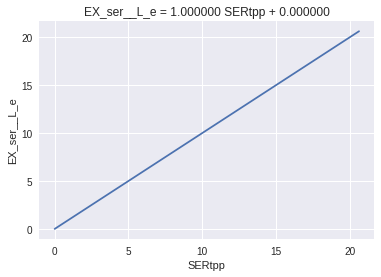

In [14]:
# Creating the trendline and plotting
z = np.polyfit(ppp_ser_prod_vs_ser_exporter['SERtpp'], ppp_ser_prod_vs_ser_exporter['flux_maximum'], 1)
p = np.poly1d(z)
plt.plot(ppp_ser_prod_vs_ser_exporter['SERtpp'],ppp_ser_prod_vs_ser_exporter['flux_maximum'],'-')
plt.ylabel('EX_ser__L_e')
plt.xlabel('SERtpp')
plt.title("EX_ser__L_e = %.6f SERtpp + %.6f"%(z[0],z[1])) # trendline equation
plt.show()

As seen, there is a 1:1 relationship, and in the altered model, the level of flux through the L-serine exporter will determine overall export and therefore the L-serine available from the production. It is beneficial to maximize the export from SERtpp as much as possible, while maintaining growth. Therefore, the phenotypic phase plane for growth affected by SERtpp flux is visualized.

In [15]:
ppp_ser_exporter = production_envelope(altered_model,
                    reactions=[altered_model.reactions.SERtpp],
                    objective=altered_model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

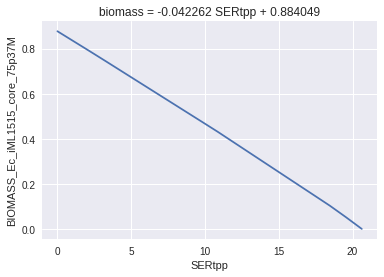

In [16]:
# Creating the trendline and plotting
z = np.polyfit(ppp_ser_exporter['SERtpp'], ppp_ser_exporter['flux_maximum'], 1)
p = np.poly1d(z)
plt.plot(ppp_ser_exporter['SERtpp'],ppp_ser_exporter['flux_maximum'],'-')
plt.ylabel('BIOMASS_Ec_iML1515_core_75p37M')
plt.xlabel('SERtpp')
plt.title("biomass = %.6f SERtpp + %.6f"%(z[0],z[1])) # trendline equation
plt.show()

Maximum biomass results in no flux through the exporter, but too much flux through SERtpp will stop the cells from growing. The equation for the relationship can be used when designing the production process of L-serine to determine the opitmal overexpression of the SERtpp exporter that will result in maxiumum L-serine production when also taking the growing biomass into account. 

Further calculations are omitted from this project but would among other things depend on the production process. In a batch production increasing biomass would be more important than in a fed-batch, where a large inoculum could be used and the population size should not grow particularly, but be maintained at a certain level. 

Another strategy for maximizing L-serine production in a bacth fermentation could be inducible production, where the expression of SERtpp  is activated from an inducible promoter only after the biomass has reached a certain level. 
